In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import numpy as np
import pickle
import cv2
from tqdm import tqdm_notebook
import os
import json
import math
import h5py


from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
directory = "/content/gdrive/My Drive/Road_Segmentation/training/images"
os.chdir('/content/gdrive/My Drive/Road_Segmentation/training/images')

In [4]:
train_dir = os.listdir(directory)
print(train_dir)

['satImage_001.png', 'satImage_002.png', 'satImage_003.png', 'satImage_004.png', 'satImage_005.png', 'satImage_006.png', 'satImage_007.png', 'satImage_008.png', 'satImage_009.png', 'satImage_010.png', 'satImage_011.png', 'satImage_012.png', 'satImage_013.png', 'satImage_014.png', 'satImage_015.png', 'satImage_016.png', 'satImage_017.png', 'satImage_018.png', 'satImage_019.png', 'satImage_020.png', 'satImage_022.png', 'satImage_021.png', 'satImage_023.png', 'satImage_024.png', 'satImage_025.png', 'satImage_026.png', 'satImage_027.png', 'satImage_029.png', 'satImage_028.png', 'satImage_030.png', 'satImage_031.png', 'satImage_032.png', 'satImage_033.png', 'satImage_035.png', 'satImage_034.png', 'satImage_036.png', 'satImage_037.png', 'satImage_038.png', 'satImage_039.png', 'satImage_040.png', 'satImage_041.png', 'satImage_042.png', 'satImage_043.png', 'satImage_044.png', 'satImage_045.png', 'satImage_046.png', 'satImage_047.png', 'satImage_048.png', 'satImage_049.png', 'satImage_050.png',

In [0]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

(400, 400, 3)


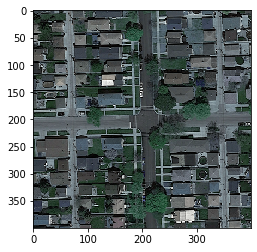

In [0]:
filename = "satImage_001.png"
mask_path = "/content/gdrive/My Drive/Road_Segmentation/training/images/" + filename
mask =cv2.imread(mask_path)
imshow(mask)
print(mask.shape)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(400, 400, 3)


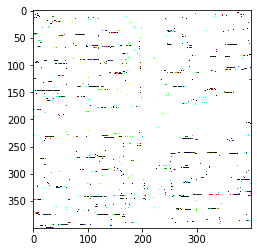

In [0]:
mask = noisy("gauss",mask)
imshow(mask)
print(mask.shape)

In [16]:
all_images = []
all_masks = []
train_dir = os.listdir(directory)
for filename in train_dir:
  # print(filename)
  image = cv2.imread(filename)
  image = cv2.resize(image,(608,608),cv2.INTER_AREA)
  # print(image.shape)
  #PREPROCESSING of training images

  all_images.append(image)

  flipVertical = cv2.flip(image, 0)
  all_images.append(flipVertical)
  flipHorizontal = cv2.flip(image, 1)
  all_images.append(flipHorizontal)
  flipBoth = cv2.flip(image, -1)
  all_images.append(flipBoth)


  img_rotate_90_clockwise = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  # img_rotate_90_clockwise = cv2.resize(img_rotate_90_clockwise,(608,608),cv2.INTER_AREA)
  all_images.append(img_rotate_90_clockwise)


  img_rotate_90_counterclockwise = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  # img_rotate_90_counterclockwise = cv2.resize(img_rotate_90_counterclockwise,(608,608),cv2.INTER_AREA)
  all_images.append(img_rotate_90_counterclockwise)

  





#########################################################################################################################################3#

  mask_path = "/content/gdrive/My Drive/Road_Segmentation/training/groundtruth/" + filename
  mask = cv2.imread(mask_path)
  #PREPROCESSING of training masks
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask,(608,608),cv2.INTER_AREA)

  ret,thresh1 = cv2.threshold(mask,64,255,cv2.THRESH_BINARY)
  mask = thresh1
  all_masks.append(mask)


  flipVerticalMask = cv2.flip(mask, 0)
  all_masks.append(flipVerticalMask)
  flipHorizontalMask = cv2.flip(mask, 1)
  all_masks.append(flipHorizontalMask)
  flipBothMask = cv2.flip(mask, -1)
  all_masks.append(flipBothMask)


  img_rotate_90_clockwise_Mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
  # img_rotate_90_clockwise = cv2.resize(img_rotate_90_clockwise,(608,608),cv2.INTER_AREA)
  all_masks.append(img_rotate_90_clockwise_Mask)


  img_rotate_90_counterclockwise_Mask = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
  # img_rotate_90_counterclockwise = cv2.resize(img_rotate_90_counterclockwise,(608,608),cv2.INTER_AREA)
  all_masks.append(img_rotate_90_counterclockwise_Mask)





  # print(thresh1.shape)



all_images = np.asarray(all_images)
all_masks = np.asarray(all_masks)
print(all_images.shape)
print(all_masks.shape)  

(600, 608, 608, 3)
(600, 608, 608)


In [0]:
all_images

In [0]:
# # Python programe to illustrate  
# # simple thresholding type on an image 
      
# # organizing imports  
# import cv2  
# import numpy as np  
  
# # path to input image is specified and   
# # image is loaded with imread command  
# image1 = cv2.imread('input1.jpg')  
  
# # cv2.cvtColor is applied over the 
# # image input with applied parameters 
# # to convert the image in grayscale  
# img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 
  
# # applying different thresholding  
# # techniques on the input image 
# # all pixels value above 120 will  
# # be set to 255 
# ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY) 
# ret, thresh2 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV) 
# ret, thresh3 = cv2.threshold(img, 120, 255, cv2.THRESH_TRUNC) 
# ret, thresh4 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO) 
# ret, thresh5 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO_INV) 
  
# # the window showing output images 
# # with the corresponding thresholding  
# # techniques applied to the input images 
# cv2.imshow('Binary Threshold', thresh1) 
# cv2.imshow('Binary Threshold Inverted', thresh2) 
# cv2.imshow('Truncated Threshold', thresh3) 
# cv2.imshow('Set to 0', thresh4) 
# cv2.imshow('Set to 0 Inverted', thresh5) 
    
# # De-allocate any associated memory usage   
# if cv2.waitKey(0) & 0xff == 27:  
#     cv2.destroyAllWindows()  

In [17]:
np.unique(all_masks)

array([  0, 255], dtype=uint8)

In [0]:
with h5py.File('/content/gdrive/My Drive/Road_Segmentation/training/train_images.h5py', 'w') as hf:
        hf.create_dataset("all_images",  data=all_images)

with h5py.File('/content/gdrive/My Drive/Road_Segmentation/training/train_masks.h5py', 'w') as hf:
        hf.create_dataset("all_masks",  data=all_masks)


In [0]:
print(np.unique(all_masks))

[  0 255]


In [0]:
img = os.listdir('/content/gdrive/My Drive/Road_Segmentation/test_set_images/'+i)
print(img)

[]


In [0]:
from shutil import copy
for i in os.listdir('/content/gdrive/My Drive/Road_Segmentation/test_set_images'):
  if(i in ".ipynb"):
    continue
  img = os.listdir('/content/gdrive/My Drive/Road_Segmentation/test_set_images/'+i)[0]
  print(img)
  copy('/content/gdrive/My Drive/Road_Segmentation/test_set_images/'+i+'/'+img,'/content/gdrive/My Drive/Road_Segmentation/test_set_images/test_images/'+img)

test_7.png
test_16.png
test_5.png
test_11.png
test_13.png
test_19.png
test_12.png
test_9.png
test_25.png
test_2.png
test_15.png
test_1.png
test_24.png
test_23.png
test_20.png
test_6.png
test_8.png
test_21.png
test_10.png
test_14.png
test_26.png
test_3.png
test_4.png
test_22.png
test_18.png
test_17.png
test_27.png
test_28.png
test_29.png
test_30.png
test_31.png
test_32.png
test_33.png
test_34.png
test_35.png
test_36.png
test_37.png
test_38.png
test_39.png
test_40.png
test_41.png
test_42.png
test_43.png
test_44.png
test_45.png
test_46.png
test_47.png
test_48.png
test_49.png
test_50.png


IndexError: ignored

In [0]:
print(len(os.listdir('/content/gdrive/My Drive/Road_Segmentation/test_set_images/test_images')))

50


In [0]:
os.chdir('/content/gdrive/My Drive/Road_Segmentation/test_set_images/test_images')

In [0]:
test_img = os.listdir('/content/gdrive/My Drive/Road_Segmentation/test_set_images/test_images')

In [0]:
print(test_img)

['test_7.png', 'test_16.png', 'test_5.png', 'test_11.png', 'test_13.png', 'test_19.png', 'test_12.png', 'test_9.png', 'test_25.png', 'test_2.png', 'test_15.png', 'test_1.png', 'test_24.png', 'test_23.png', 'test_20.png', 'test_6.png', 'test_8.png', 'test_21.png', 'test_10.png', 'test_14.png', 'test_26.png', 'test_3.png', 'test_4.png', 'test_22.png', 'test_18.png', 'test_17.png', 'test_27.png', 'test_28.png', 'test_29.png', 'test_30.png', 'test_31.png', 'test_32.png', 'test_33.png', 'test_34.png', 'test_35.png', 'test_36.png', 'test_37.png', 'test_38.png', 'test_39.png', 'test_40.png', 'test_41.png', 'test_42.png', 'test_43.png', 'test_44.png', 'test_45.png', 'test_46.png', 'test_47.png', 'test_48.png', 'test_49.png', 'test_50.png']


In [0]:
all_test_img = []
for i in test_img:
  x = cv2.imread(i)
  # x = cv2.resize(x, (400,400), interpolation = cv2.INTER_AREA)
  all_test_img.append(x)
all_test_img = np.asarray(all_test_img)




In [0]:
print(all_test_img.shape)

(50, 608, 608, 3)


In [0]:
with h5py.File('/content/gdrive/My Drive/Road_Segmentation/actual_test_images.h5py', 'w') as hf:
        hf.create_dataset("all_test_images",  data=all_test_img)